# Classification

In [26]:
# library
import csv
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import plotly.offline as py
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score


In [2]:
# read csv
data=list(csv.DictReader(open('/content/master.csv')))
suicide=pd.read_csv('/content/master.csv', thousands=r',')
suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  int64  
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.5+ MB


In [3]:
# 'HDI for year' column : NA -> 0
suicide['HDI for year'].replace(np.nan, 0, inplace=True)
suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        27820 non-null  float64
 9    gdp_for_year ($)   27820 non-null  int64  
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.5+ MB


In [4]:
# change column name
suicide.columns=['country','year','sex','age','suicides_no','population','suicides_100k_pop',
                 'country_year','HDI_for_year','gdp_for_year','gdp_per_capita','generation']
suicide.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_100k_pop', 'country_year', 'HDI_for_year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')

## 1. visualization

Text(0, 0.5, 'Country')

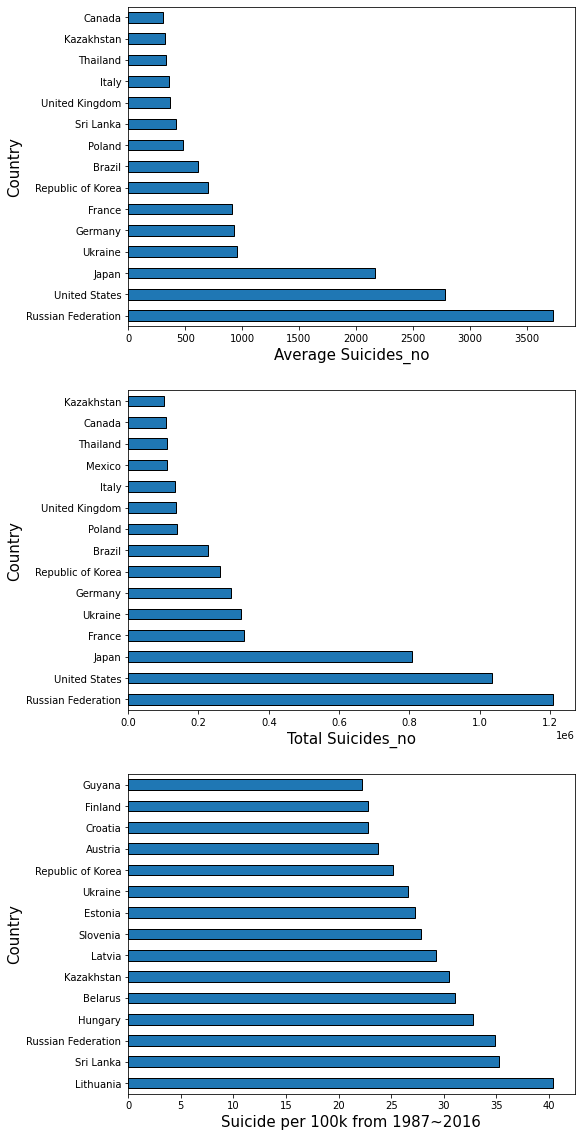

In [ ]:
plt.figure(figsize=(8,20))
# Average suicide rate in the top 15 countries
plt.subplot(3,1,1)
suicide.groupby(['country']).suicides_no.mean().nlargest(15).plot(kind='barh', edgecolor='black')
plt.xlabel('Average Suicides_no', size=15)
plt.ylabel('Country', size=15)

# Total suicide rate in the top 15 countries
plt.subplot(3,1,2)
suicide.groupby(['country']).suicides_no.sum().nlargest(15).plot(kind='barh', edgecolor='black')
plt.xlabel('Total Suicides_no', size=15)
plt.ylabel('Country', size=15)

# 100k suicide rate in the top 15 countries
plt.subplot(3,1,3)
suicide.groupby(['country']).suicides_100k_pop.mean().nlargest(15).plot(kind='barh', edgecolor='black')
plt.xlabel('Suicide per 100k from 1987~2016', size=15)
plt.ylabel('Country', size=15)


Text(0, 0.5, 'Total num of suicide in the world')

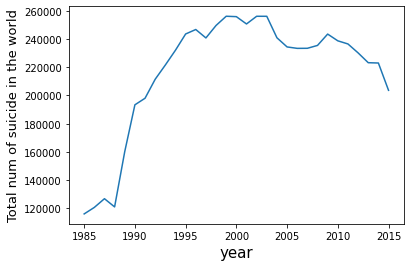

In [ ]:
# World Suicide Total Count by Year (Excluding 2016)
df=pd.DataFrame(suicide.groupby('year').suicides_no.sum())
plt.plot(df.index[:-1], df[:-1])
plt.xlabel('year',size=15)
plt.ylabel('Total num of suicide in the world', size=13)

Text(1995, 15.662670940170946, '15.66')

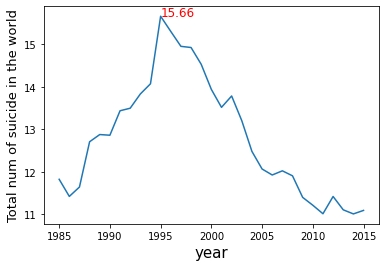

In [19]:
# World Suicide Average Count by Year (Excluding 2016)
df=pd.DataFrame(suicide.groupby('year').suicides_100k_pop.mean())
plt.figure()
plt.plot(df.index[:-1], df[:-1])
max_val=df['suicides_100k_pop'].max()
plt.xlabel('year',size=15)
plt.ylabel('Total num of suicide in the world', size=13)
plt.text(1995, max_val, np.round(max_val,2), color='red', fontsize=12)

Text(0.5, 1.0, 'Rates of Suicides by Gender')

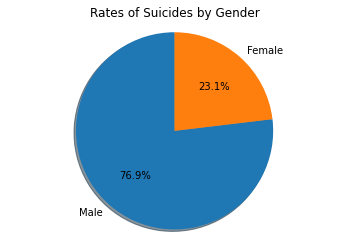

In [ ]:
# Male and female suicide rate
labels = 'Male', 'Female'
values = [np.sum(suicide[suicide.sex.eq("male")].suicides_no), 
          np.sum(suicide[suicide.sex.eq("female")].suicides_no)]
fig1, ax1 = plt.subplots()
ax1.pie(values,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Rates of Suicides by Gender')

Text(0.5, 1.0, 'Rates of suicides of Age')

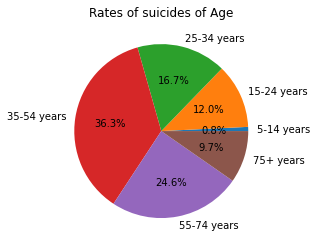

In [ ]:
# Suicide rate by age
labels = ['5-14 years', '15-24 years','25-34 years','35-54 years','55-74 years','75+ years']
df=suicide.groupby('age')['suicides_no'].sum()/np.sum(suicide['suicides_no'])
df=df.reindex(labels)

plt.pie(df, labels=labels, autopct='%1.1f%%', startangle=0)
plt.title('Rates of suicides of Age')

In [ ]:
# Population by country, HDI, GDP bar graph

countries=suicide['country'].unique()
def getvalofcountries(data, column_key):
    print(column_key)
    values = []
    for eachcon in countries:
        if column_key == 'population':
            values.append(np.sum(suicide[suicide.country.eq(eachcon)].population))
        elif column_key == 'HDI_for_year':
            values.append(float(suicide[suicide.country.eq(eachcon)].HDI_for_year.iloc[0]))
        elif column_key == 'gdp_for_year':
            values.append(float(suicide[suicide.country.eq(eachcon)].gdp_for_year.iloc[0]))

    df = pd.DataFrame(values, index = countries,columns =['values']).sort_values(by='values', ascending=False)
    df = df[(df.values != 0)] # remove empty values
    df=df.iloc[:30,:]
    df.plot(kind='barh',figsize=(6,10), fontsize=10)
    plt.xlabel('Values', size=20)
    plt.ylabel('Country', fontsize=20)
    plt.title("Country vs "+column_key, fontsize=20)
    
    

population


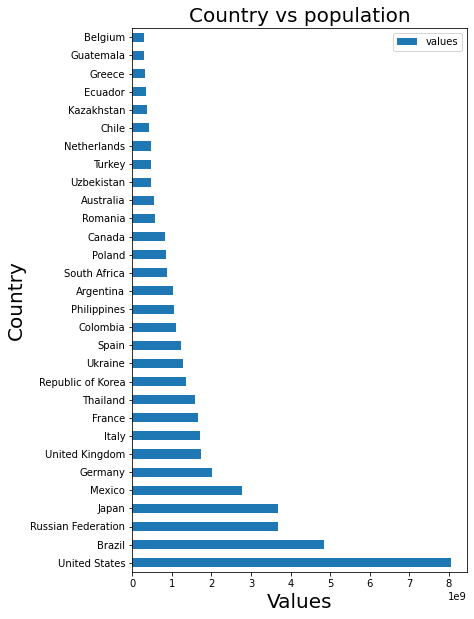

In [ ]:
getvalofcountries(suicide, 'population')

HDI_for_year


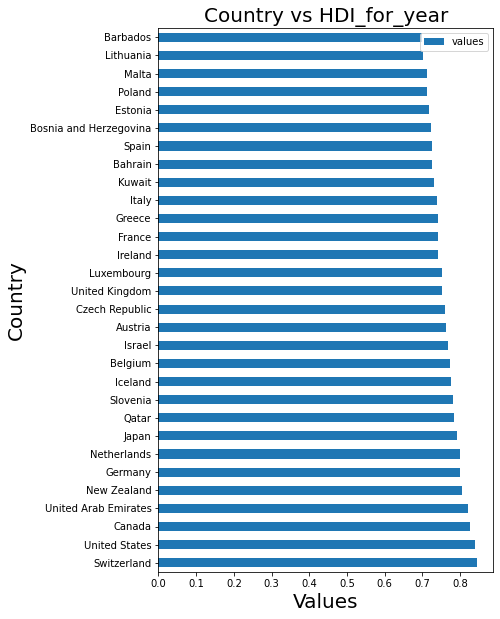

In [ ]:
getvalofcountries(suicide, 'HDI_for_year')

gdp_for_year


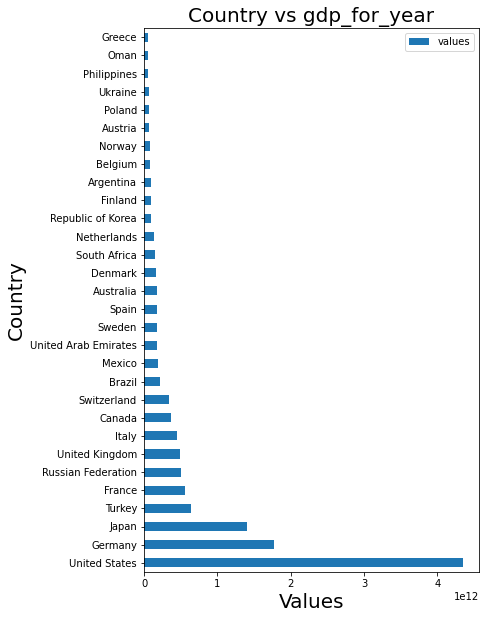

In [ ]:
getvalofcountries(suicide, 'gdp_for_year')

Text(0, 0.5, 'Number of Suicides')

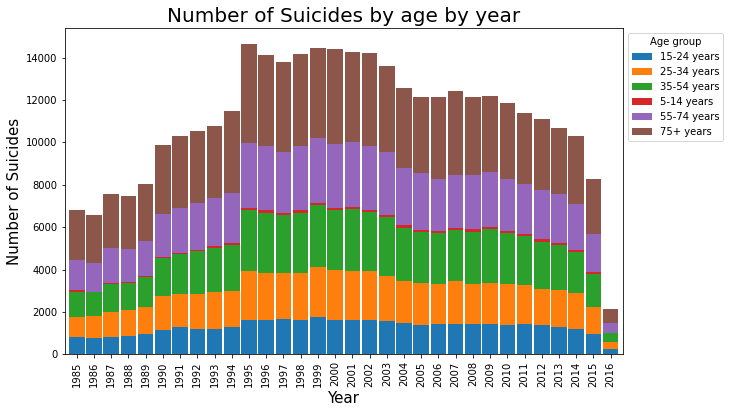

In [ ]:
# Sum of suicide rates by year and age

yr_age_suicide=pd.DataFrame(suicide.groupby(['age','year'])['suicides_100k_pop'].sum().unstack())
yr_age_suicide=yr_age_suicide.fillna(0)

yr_age_suicide=yr_age_suicide.T
yr_age_suicide.plot(kind='bar',stacked = True, figsize=(10,6), width=0.9)
plt.legend(bbox_to_anchor=(1,1), title = 'Age group')
plt.title('Number of Suicides by age by year', size=20)
plt.xlabel('Year', size=15)
plt.ylabel('Number of Suicides', size=15)

In [ ]:
# Number of suicides by year, gender, and age
yr_age_sex_suicide=pd.DataFrame(suicide.groupby(['age', 'sex', 'year'])['suicides_no'].sum().unstack())
yr_age_sex_suicide=yr_age_sex_suicide.fillna(0)
yr_age_sex_suicide

# male
yr_age_male=pd.DataFrame(yr_age_sex_suicide.iloc[[1,3,5,7,9,11],:])

# female
yr_age_female=pd.DataFrame(yr_age_sex_suicide.iloc[[0,2,4,6,8,10],:])

yr_age_female

,year,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
age,sex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15-24 years,female,4690.0,4821.0,4046.0,3447.0,4004.0,5308.0,5034.0,5448.0,5181.0,5372.0,5976.0,6243.0,6369.0,6666.0,6518.0,6434.0,6100.0,6227.0,6531.0,5853.0,5869.0,5933.0,5876.0,6163.0,6371.0,6164.0,6468.0,5940.0,5666.0,5452.0,5029.0,238.0
25-34 years,female,4894.0,5058.0,4923.0,4468.0,5422.0,6772.0,6486.0,6830.0,6812.0,6846.0,7117.0,7432.0,7455.0,7439.0,7444.0,7269.0,6738.0,7254.0,7287.0,6833.0,6936.0,6763.0,7254.0,7387.0,7596.0,7363.0,7437.0,7080.0,6719.0,6871.0,6265.0,373.0
35-54 years,female,9476.0,10047.0,10551.0,10014.0,12246.0,14622.0,14824.0,15840.0,15947.0,16238.0,17304.0,17327.0,17223.0,17446.0,18147.0,18203.0,17863.0,18786.0,18676.0,18362.0,17447.0,17642.0,17989.0,18408.0,18751.0,18468.0,18344.0,17986.0,17524.0,17424.0,15876.0,1232.0
5-14 years,female,351.0,303.0,271.0,244.0,308.0,384.0,379.0,455.0,479.0,475.0,538.0,538.0,578.0,662.0,596.0,580.0,649.0,677.0,600.0,607.0,566.0,616.0,585.0,628.0,724.0,675.0,748.0,608.0,719.0,761.0,693.0,0.0
55-74 years,female,9057.0,9308.0,10373.0,9869.0,12727.0,14891.0,14887.0,15129.0,15288.0,15129.0,15808.0,15495.0,14941.0,15451.0,15569.0,15026.0,14121.0,14680.0,14618.0,13902.0,13730.0,13608.0,14004.0,13878.0,14216.0,14297.0,14227.0,14071.0,13810.0,13926.0,12881.0,1119.0
75+ years,female,4011.0,4315.0,4842.0,4973.0,6654.0,8141.0,8012.0,7865.0,7624.0,7472.0,7761.0,7548.0,7560.0,7967.0,7941.0,7742.0,7528.0,7925.0,7915.0,7675.0,7487.0,7477.0,7616.0,7509.0,7262.0,7255.0,7392.0,7326.0,7021.0,7122.0,6504.0,542.0


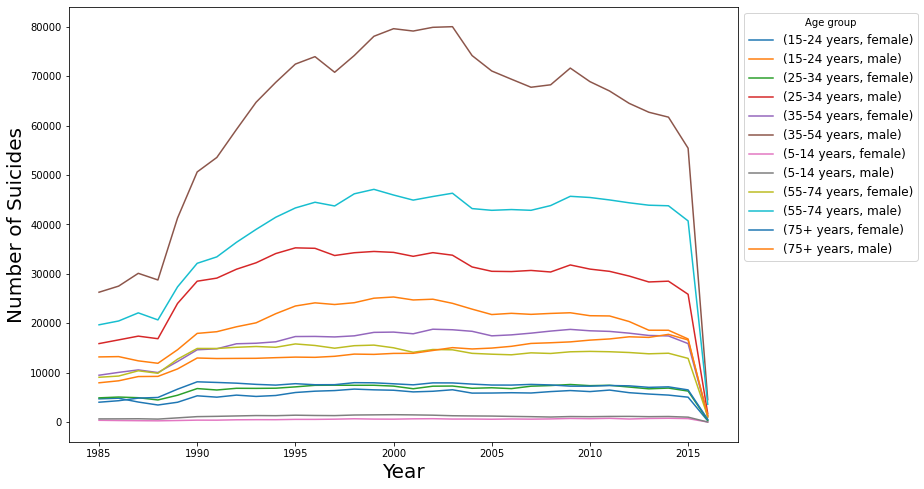

In [ ]:
# By year
yr_age_sex_suicide.T.plot(figsize=(12,8))
plt.xlabel('Year', size=20)
plt.ylabel('Number of Suicides',size=20)
plt.legend(bbox_to_anchor=(1,1), title = 'Age group', fontsize=12)

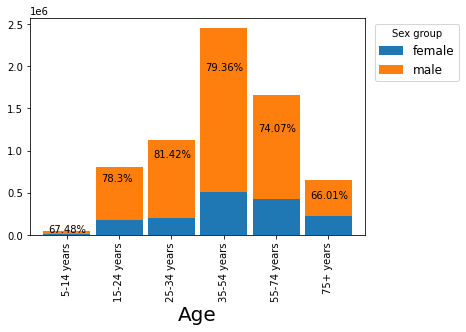

In [ ]:
# Number of suicides by gender and age
age_sex_suicide=pd.DataFrame(suicide.groupby(['age','sex'])['suicides_no'].sum().unstack())
age_sex_suicide=age_sex_suicide.reindex(labels=labels)

bars=age_sex_suicide.plot(kind='bar', stacked=True, width=0.9)
plt.xlabel('Age', size=20)
plt.legend(bbox_to_anchor=(1.3,1), title = 'Sex group', fontsize=12)
prop=age_sex_suicide.apply(lambda x: x/np.sum(x), axis=1)['male']

cn=0
for i in bars.patches[6:]:
  left, bottom, width, height=i.get_bbox().bounds
  plt.text(left+0.1, height+0.1, str(np.round(prop[cn]*100,2))+'%')
  cn+=1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()


([<matplotlib.patches.Wedge at 0x7fb26d1add30>,
 [Text(5.789933224602958, 5.826111713267556, 'Russian Federation'),
  Text(3.4234898393180018, 5.750450268482685, 'Unites States'),
  Text(2.9535769196229, 3.9246082582474777, 'Japan'),
  Text(3.7614871345192102, 3.02450050914297, 'France'),
  Text(4.441861422497426, 2.851024589083883, 'Ukraine'),
  Text(5.0944493784913965, 2.9608021776226447, 'Germany'),
  Text(5.605120360227825, 3.274761660161615, 'Republic of Korea'),
  Text(5.936576430474023, 3.688366979844638, 'Brazil'),
  Text(6.0890460758654275, 4.055666151664442, 'Poland'),
  Text(6.143265339501291, 4.351073763245996, 'United Kingdom')],
 [Text(5.2669873227368935, 5.288498856537466, '25.4%'),
  Text(3.912812639628001, 5.182063782808737, '21.7%'),
  Text(3.656496501612491, 4.186149959044078, '17.0%'),
  Text(4.097174800646842, 3.6951820958961656, '6.9%'),
  Text(4.468288048634959, 3.600558866773027, '6.7%'),
  Text(4.824245115540762, 3.6604375514305336, '6.1%'),
  Text(5.1027929237

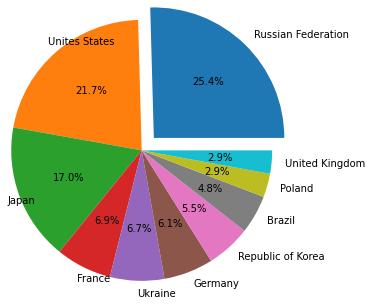

In [ ]:
# Suicide rates in the top 10 countries
gsdcountry = (pd.DataFrame(suicide.groupby(['country','sex'])['suicides_no'].sum().unstack()))/1000000
gsdcountry['Suicide number']=gsdcountry.apply(lambda gsdcountry: gsdcountry['female']+gsdcountry['male'], axis = 1)
gsdcountry = gsdcountry.sort_values(by='Suicide number',ascending=False)
gsdcountry10 = pd.DataFrame(gsdcountry.iloc[0:10,2])

top10country = ["Russian Federation","Unites States","Japan","France","Ukraine","Germany","Republic of Korea","Brazil","Poland","United Kingdom"]

plt.pie(gsdcountry10,
               labels = top10country,
               autopct = '%.1f%%',
               startangle =0,
               radius = 1.5,
               frame = 0,
               center = (4.5,4.5),
               explode=(0.2,0,0,0,0,0,0,0,0,0)
               )

상관계수 : 0.54


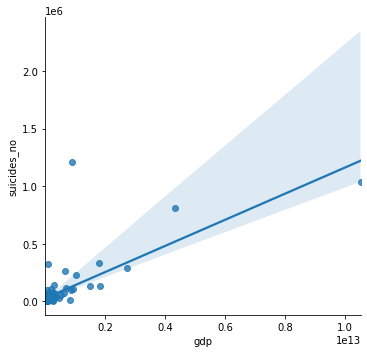

In [ ]:
#The correlation between perGDP vs suicide number
df=pd.DataFrame(columns=['gdp','suicides_no'])
df['gdp']=suicide.groupby(['country']).gdp_for_year.mean()
df['suicides_no']=list(suicide.groupby(['country']).suicides_no.sum().to_frame().suicides_no)

sns.lmplot(x = "gdp",y = "suicides_no", data = df)
rsquare=np.round(stats.pearsonr(df['gdp'], df['suicides_no'])[0]**2,2)
print(f'상관계수 : {rsquare}')


In [ ]:
suicide.head()

,country,year,sex,age,suicides_no,population,suicides_100k_pop,country_year,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,0.0,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,0.0,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,0.0,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,0.0,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,0.0,2156624900,796,Boomers


In [ ]:
gdp_df=pd.DataFrame(columns=['country','gdp','gdp_per_capita','suicides_no','HDI'])
gdp_df['country']=countries
gdp_df['gdp']=list(suicide.groupby(['country']).gdp_for_year.mean())
gdp_df['gdp_per_capita']=list(suicide.groupby(['country']).gdp_per_capita.mean())
gdp_df['suicides_no']=list(suicide.groupby(['country']).suicides_no.sum().to_frame().suicides_no)
gdp_df['suicides_100k_pop'] = list(suicide.groupby(['country']).suicides_100k_pop.sum().to_frame().suicides_100k_pop)
gdp_df['HDI']=list(suicide.groupby(['country']).HDI_for_year.mean())
gdp_df.head()

,country,gdp,gdp_per_capita,suicides_no,HDI,suicides_100k_pop
0,Albania,5.211661e+09,1859.045455,1970,0.122364,924.76
1,Antigua and Barbuda,8.035452e+08,10448.185185,11,0.086852,179.14
2,Argentina,2.742565e+11,7914.096774,82219,0.251484,3894.59
3,Armenia,5.386592e+09,1873.919463,1905,0.222322,976.21
4,Aruba,2.196223e+09,24221.642857,101,0.000000,1596.52


Text(0.5, 1.0, 'Correlation between the features by Countries')

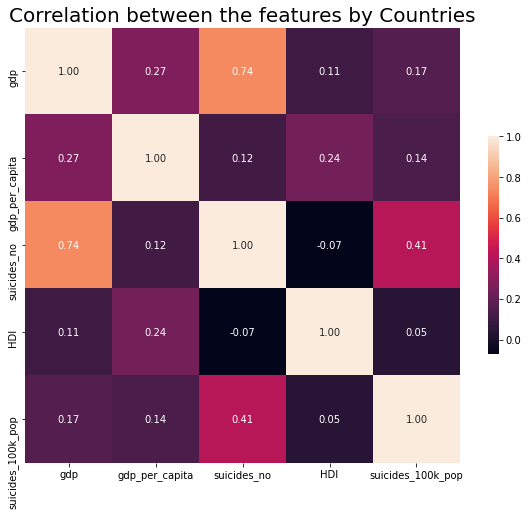

In [ ]:
correlation= gdp_df.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation, vmax=1, square=True, annot=True,fmt='.2f', 
                  cbar_kws={"shrink": .5}, robust=True)
plt.title('Correlation between the features by Countries', fontsize=20)

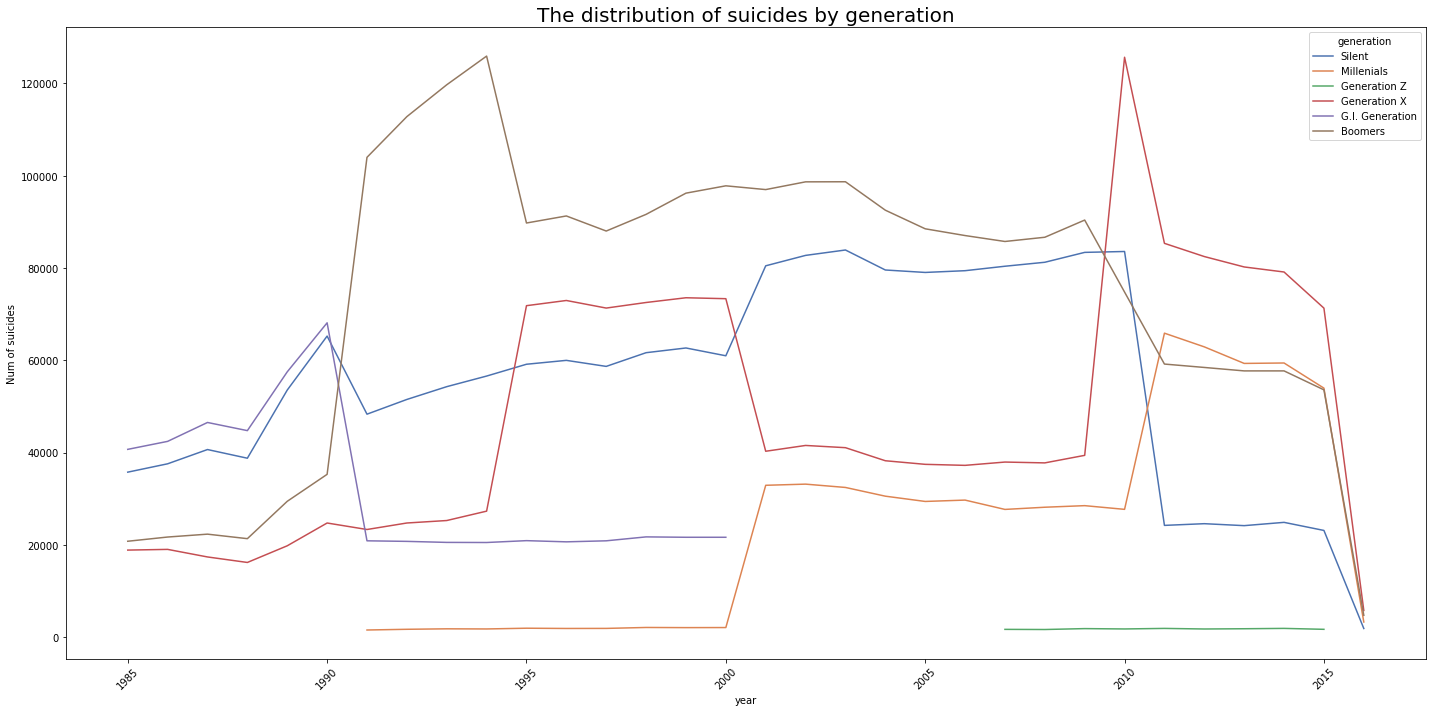

In [ ]:
# Number of suicides by generation
suic_sum_yr = pd.DataFrame(suicide['suicides_no'].groupby([suicide['generation'],suicide['year']]).sum())
suic_sum_yr = suic_sum_yr.reset_index().sort_index(ascending=False)
most_cont_yr = suic_sum_yr
fig = plt.figure(figsize=(20,10))
plt.title('The distribution of suicides by generation', fontsize=20)

sns.lineplot(x='year',y='suicides_no',hue='generation',data=most_cont_yr,palette='deep');
plt.ylabel('Num of suicides', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

## 2. Model Construction

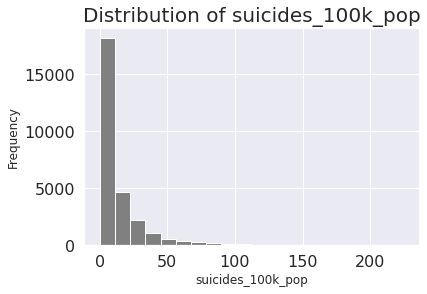

In [ ]:
# Histogram of suicide rate
plt.hist(suicide.suicides_100k_pop,bins=20,color='gray')
plt.title("Distribution of suicides_100k_pop", fontsize=20)
plt.xlabel('suicides_100k_pop', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

Text(0, 0.5, 'Frequency')

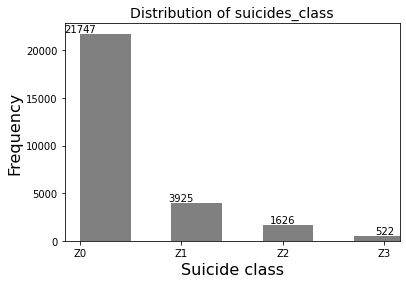

In [5]:
# Create 4 labels according to suicide rate
#  > 80    = Z3
#  40 - 79 = Z2
#  20 - 39 = Z1
#  0 - 19  = Z0
import copy

labels=['Z0', 'Z1', 'Z2','Z3']
suicide2 = copy.deepcopy(suicide)
suicide2['suicides_class'] = pd.cut(x=suicide['suicides_100k_pop'], bins=[-0.1,19, 39, 79, 500], labels=['Z0', 'Z1', 'Z2','Z3'])
y=suicide2['suicides_class'].value_counts()

plt.hist(suicide2['suicides_class'], color='gray',width=0.5,align='mid')
plt.title("Distribution of suicides_class", fontsize=14)
for i, v in enumerate(labels):
    plt.text(v, y[i], y[i], fontsize=10, color='black',horizontalalignment='center', verticalalignment='bottom')
plt.xlabel('Suicide class', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


In [6]:
# resampling : As many as Z0 data for data for Z1 to Z3
# >> bootstrap 
from sklearn.utils import resample

suicide_Z0=suicide2[suicide2['suicides_class']=='Z0']
suicide_Z1=suicide2[suicide2['suicides_class']=='Z1']
suicide_Z2=suicide2[suicide2['suicides_class']=='Z2']
suicide_Z3=suicide2[suicide2['suicides_class']=='Z3']

n_samples=len(suicide_Z0)

Z1_resampled=resample(suicide_Z1, replace=True, n_samples=n_samples, random_state=42)
Z2_resampled=resample(suicide_Z2, replace=True, n_samples=n_samples, random_state=42)
Z3_resampled=resample(suicide_Z3, replace=True, n_samples=n_samples, random_state=42)

suicide_resampled=pd.concat([suicide_Z0, Z1_resampled, Z2_resampled, Z3_resampled])
suicide_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86988 entries, 0 to 6774
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country            86988 non-null  object  
 1   year               86988 non-null  int64   
 2   sex                86988 non-null  object  
 3   age                86988 non-null  object  
 4   suicides_no        86988 non-null  int64   
 5   population         86988 non-null  int64   
 6   suicides_100k_pop  86988 non-null  float64 
 7   country_year       86988 non-null  object  
 8   HDI_for_year       86988 non-null  float64 
 9   gdp_for_year       86988 non-null  int64   
 10  gdp_per_capita     86988 non-null  int64   
 11  generation         86988 non-null  object  
 12  suicides_class     86988 non-null  category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 8.7+ MB


No handles with labels found to put in legend.


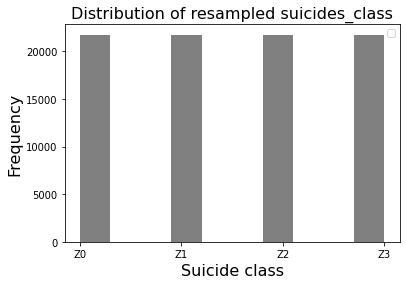

In [7]:
# resampled num of class
plt.hist(suicide_resampled['suicides_class'], color='gray')
plt.title("Distribution of resampled suicides_class", fontsize=16)
plt.xlabel('Suicide class', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(fontsize='medium')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [8]:
# drop 기준
# 1. country, country-year : id value
# 2. generation : Can be estimated by age and year
# 3. suicides_100k_pop = suicides_no / population >> Removed because the label was created based on suicide_100k_pop


suicide_resampled2=suicide_resampled.drop(['country','country_year','generation','suicides_no',
                                           'suicides_100k_pop'], axis = 1) 

In [9]:
# Onehot Encoding : sex, age, year
sex_onehot=pd.get_dummies(suicide_resampled2['sex'], prefix='sex', drop_first=True)
age_onehot=pd.get_dummies(suicide_resampled2['age'], prefix='age', drop_first=True)
year_onehot=pd.get_dummies(suicide_resampled2['year'], prefix='year', drop_first=True)

suicide_resampled2=pd.concat([suicide_resampled2, sex_onehot, age_onehot, year_onehot], axis=1).drop(['sex','age','year'], axis=1)
suicide_resampled2.head()

,population,HDI_for_year,gdp_for_year,gdp_per_capita,suicides_class,sex_male,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years,year_1986,year_1987,year_1988,year_1989,year_1990,year_1991,year_1992,year_1993,year_1994,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,312900,0.0,2156624900,796,Z0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,308000,0.0,2156624900,796,Z0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,289700,0.0,2156624900,796,Z0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21800,0.0,2156624900,796,Z0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,274300,0.0,2156624900,796,Z0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# train, test split
from sklearn.model_selection import train_test_split

def tr_tst_split(df):
    X=df.drop(['suicides_class'], axis=1)
    Y=df['suicides_class']

    X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, Y, test_size=0.25, random_state=42)
    
    return X_tr, X_tst, Y_tr, Y_tst

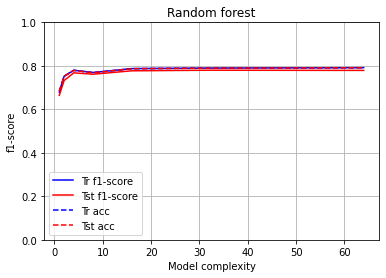

In [32]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

complexities = []
train_errors = []
test_errors = []
train_acc=[]
test_acc=[]
for n_estimators in [1,2,4,8,16,32,64]:
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=8) 
    clf.fit(X_tr, Y_tr)

    complexities.append(n_estimators)
    train_errors.append(f1_score(Y_tr, clf.predict(X_tr), average='weighted'))
    test_errors.append(f1_score(Y_tst, clf.predict(X_tst), average='weighted'))
    train_acc.append(clf.score(X_tr, Y_tr))
    test_acc.append(clf.score(X_tst, Y_tst))

plt.plot(complexities, train_errors, c='b', label='Tr f1-score')
plt.plot(complexities, test_errors, c='r', label='Tst f1-score')
plt.plot(complexities, train_acc, c='b', linestyle='--', label='Tr acc')
plt.plot(complexities, train_acc, c='r', linestyle='--', label='Tst acc')
plt.ylim(0,1)
plt.ylabel('f1-score')
plt.xlabel('Model complexity')
plt.title('Random forest')
plt.legend()
plt.grid(True)

# Train and test results are quite low, about 0.68

In [11]:
# Remove year, gdp_for_year, empty HDI from above variable
# 1. year : If you look at the number of suicides by year, the number of suicides is similar except for the first half.
# 2. gdp_for_year : Only certain countries have high GDP and the gap is large
suicide_resampled2=suicide_resampled.drop(['country','country_year','generation','suicides_no','suicides_100k_pop',
                                           'year','gdp_for_year'], axis = 1)
suicide_resampled2=pd.concat([suicide_resampled2, sex_onehot, age_onehot], axis=1).drop(['sex','age'],axis=1)
suicide_resampled2=suicide_resampled2[suicide_resampled2.HDI_for_year!=0]
suicide_resampled2.head()

,population,HDI_for_year,gdp_per_capita,suicides_class,sex_male,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years
72,232900,0.619,835,Z0,1,1,0,0,0,0
73,178000,0.619,835,Z0,1,0,0,0,1,0
74,40800,0.619,835,Z0,0,0,0,0,0,1
75,283500,0.619,835,Z0,0,0,0,0,0,0
76,241200,0.619,835,Z0,1,0,0,0,0,0


In [12]:
# train test split
X_tr, X_tst, Y_tr, Y_tst = tr_tst_split(suicide_resampled2)

In [14]:
# GridSearch with RandomForest
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [RandomForestClassifier()],
     'classifier__criterion' : ['entropy', 'gini'],
    'classifier__max_depth' : [2,3,4,5,6,8,16,None],
     'classifier__n_estimators':[1,2,4,8,16,32,64],
     'classifier__max_features' : [4,6,10,16]
    }
]
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1,scoring='f1_macro')

best_clf = clf.fit(X_tr, Y_tr)
print(f"Best paramters are : {best_clf.best_params_}")
print("Best f1 score (Tr) :", best_clf.best_score_)
print("Best f1 score (Val) :", f1_score(Y_tst, best_clf.predict(X_tst), average='macro'))

Best paramters are : {'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=64,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 6, 'classifier__n_estimators': 64}
Best f1 score (Tr) : 0.9783656141004716
Best f1 score (Val) : 0.9800127330008036


Classification Report
----------------------------------------------------
              precision    recall  f1-score   support

          Z0       0.99      0.93      0.96      1685
          Z1       0.95      0.99      0.97      1665
          Z2       0.99      1.00      0.99      1492
          Z3       0.99      1.00      1.00      1187

    accuracy                           0.98      6029
   macro avg       0.98      0.98      0.98      6029
weighted avg       0.98      0.98      0.98      6029

----------------------------------------------------


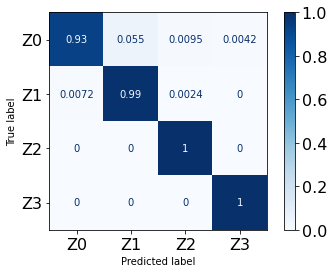

In [66]:
# Confusion Matrix & Classification Report

print('Classification Report')
print('-----------------------------------------------------')
print(classification_report(Y_tst, best_clf.predict(X_tst)))
print('-----------------------------------------------------')
plot_confusion_matrix(best_clf, X_tst, Y_tst, display_labels=suicide_resampled2['suicides_class'].unique(),
                      cmap=plt.cm.Blues, normalize='true')

In [25]:
best_clf.best_estimator_[0].feature_importances_

array([0.26967544, 0.19828251, 0.21713544, 0.14273141, 0.01476298,
       0.01518926, 0.04079481, 0.01991683, 0.08151131])

In [29]:
# feature importances
features = X_tr.columns.values
feature_importances = best_clf.best_estimator_[0].feature_importances_
trace=go.Scatter(y=feature_importances, x=features, mode='markers',
                 marker=dict(sizemode='diameter',
                             sizeref=1, size=13,
                             color=feature_importances,
                             colorscale='Portland', showscale=True),
                 text=features)
data=[trace]

layout=go.Layout(autosize=True, title='Feature Importances', hovermode='closest',
                 xaxis=dict(ticklen=8, showgrid=False, zeroline=False, showline=False),
                 yaxis=dict(title='Feature Importances', showgrid=False, zeroline=False, 
                            ticklen=8, gridwidth=2),
                 showlegend=False, )
fig=go.Figure(data=data, layout=layout)
py.iplot(fig)

In [34]:
# GridSearch with DecisionTree
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('classifier' , DecisionTreeClassifier())])
param_grid = [
    {'classifier' : [DecisionTreeClassifier()],
     'classifier__criterion' : ['entropy', 'gini'],
    'classifier__max_depth' : [2,3,4,5,6,8,16,32,None], #2,4,8,16,32,None
     'classifier__splitter' : ['best', 'random']
    }
]
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1,scoring='f1_macro')

best_clf = clf.fit(X_tr, Y_tr)
print(f"Best paramters are : {best_clf.best_params_}")
print("Best f1 score (Tr) :", best_clf.best_score_)
print("Best f1 score (Val) :", f1_score(Y_tst, best_clf.predict(X_tst), average='macro'))
print('Classification Report')
print('-----------------------------------------------------')
print(classification_report(Y_tst, best_clf.predict(X_tst)))

Best paramters are : {'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=32, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'classifier__criterion': 'entropy', 'classifier__max_depth': 32, 'classifier__splitter': 'best'}
Best f1 score (Tr) : 0.9716506246117564
Best f1 score (Val) : 0.9759693655630564
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

          Z0       0.99      0.92      0.95      1685
          Z1       0.93      0.99      0.96      1665
          Z2       0.99      1.00      0.99      1492
          Z3       0.99      1.00      1.00      1187

    accur

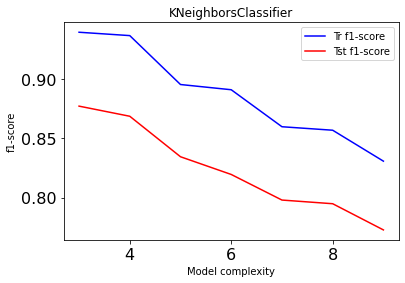

In [68]:
# GridSearch with KNN
from sklearn.neighbors import KNeighborsClassifier

complexities = []
train_errors = []
test_errors = []
for n in range(3,10):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_tr, Y_tr)
    complexities.append(n)
    train_errors.append(f1_score(Y_tr, clf.predict(X_tr), average='macro'))
    test_errors.append(f1_score(Y_tst, clf.predict(X_tst), average='macro'))
plt.plot(complexities, train_errors, c='b', label='Tr f1-score')
plt.plot(complexities, test_errors, c='r', label='Tst f1-score')
#plt.ylim(0,1)
plt.ylabel('f1-score')
plt.xlabel('Model complexity')
plt.title('KNeighborsClassifier')
plt.legend()

# >> As neighbors increase, f1 score decreases

In [71]:
pipe = Pipeline([('classifier' , KNeighborsClassifier())])
param_grid = [
    {'classifier' : [KNeighborsClassifier()],
     'classifier__n_neighbors' :list(range(1,10)),
     'classifier__weights':['uniform','distance'],
     'classifier__metric':['euclidean','manhattan'],
    }
]
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1,scoring='f1_macro')

best_clf = clf.fit(X_tr, Y_tr)
print(f"Best paramters are : {best_clf.best_params_}")
print("Best f1 score (Tr) :", best_clf.best_score_)
print("Best f1 score (Val) :", f1_score(Y_tst, best_clf.predict(X_tst), average='macro'))

Best paramters are : {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'), 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}
Best f1 score (Tr) : 0.9242752564148133
Best f1 score (Val) : 0.9327044636176137


In [73]:
# GridSearch with LogisticRegression
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('classifier' , LogisticRegression())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
]
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1,scoring='f1_macro')

best_clf = clf.fit(X_tr, Y_tr)
print(f"Best paramters are : {best_clf.best_params_}")
print("Best f1 score (Tr) :", best_clf.best_score_)
print("Best f1 score (Val) :", f1_score(Y_tst, best_clf.predict(X_tst), average='macro'))

Best paramters are : {'classifier': LogisticRegression(C=0.615848211066026, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 0.615848211066026, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best f1 score (Tr) : 0.5769272263411996
Best f1 score (Val) : 0.5683895280274545


In [18]:
# GridSearch with SVM
from sklearn.svm import SVC

pipe = Pipeline([('classifier' , SVC())])
param_grid = [
    {'classifier' : [SVC()],
     'classifier__kernel' : ['rbf','linear'],
     'classifier__C' : [1,10,100],
     'classifier__gamma' : [0.1]
    }
]
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1,scoring='f1_macro')

best_clf = clf.fit(X_tr, Y_tr)
print(f"Best paramters are : {best_clf.best_params_}")
print("Best f1 score (Tr) :", best_clf.best_score_)
print("Best f1 score (Val) :", f1_score(Y_tst, best_clf.predict(X_tst), average='macro'))


Best paramters are : {'classifier': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 1, 'classifier__gamma': 0.1}
Best f1 score (Tr) : 0.9907826727255369
Best f1 score (Val) : 0.995372223412031


Text(4, 0.995, '0.995')

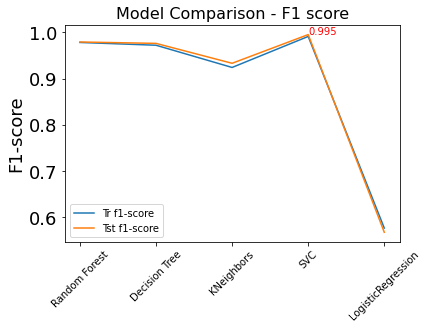

In [25]:
# model comparison
tr_score= [0.978,0.972,0.924,0.991,0.577]
tst_score = [0.979,0.976,0.933,0.995,0.568]


x = np.array([1,2,3,4,5])
model = ['Random Forest','Decision Tree','KNeighbors','SVC','LogisticRegression']
plt.xticks(x, model,rotation=45)

plt.plot(x, tr_score, label="Tr f1-score")
plt.plot(x, tst_score, label="Tst f1-score")

plt.title('Model Comparison - F1 score', fontsize=16)
plt.ylabel('F1-score', fontsize=18)
plt.legend(fontsize='medium')
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=18)
plt.text(4, 0.995, 0.995, color='red')